# NBA MVP Vorhersage – End-to-End Machine Learning

In diesem Projekt entwickeln wir ein Machine-Learning-Modell, um vorherzusagen, welcher Spieler in der NBA den Most Valuable Player (MVP) Award gewinnen wird. Dafür nutzen wir historische Spieler- und Teamstatistiken als Datengrundlage, aus denen wir relevante Merkmale (**Features**) extrahieren und verarbeiten.

---

### Problemstellung

Da pro NBA-Saison genau ein Spieler zum MVP gewählt wird, handelt es sich hierbei um ein **Klassifikationsproblem mit einer sehr starken Klassenungleichverteilung (Imbalance)**:

* **Problemtyp:**
    * Primär eine **binäre Klassifikation** pro Spieler und Saison („MVP“ vs. „Nicht-MVP“).
    * Alternativ kann man es auch als **Multi-Klassen-Klassifikation** betrachten (1 MVP vs. viele Nicht-MVPs pro Saison).
* **Klassenverteilung:** Extrem unausgeglichen, da pro Saison nur genau ein Spieler als MVP ausgezeichnet wird und viele weitere Spieler diese Auszeichnung nicht erhalten.

---

### Zielmetriken

* **Precision:** Der Anteil der korrekt als MVP klassifizierten Spieler an allen Spielern, die das Modell als MVP vorhergesagt hat.
* **Recall:** Der Anteil der korrekt als MVP vorhergesagten Spieler am tatsächlich gewählten MVP.
* **F1-Score:** Das harmonische Mittel von Precision und Recall. Er bietet einen Ausgleich zwischen beiden Metriken und ist besonders nützlich bei unausgeglichenen Klassen.
* **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve):** Eine Metrik, die unabhängig von einem Schwellenwert die Gesamtqualität der Modellvorhersagen bewertet. Ein höherer AUC-Wert deutet auf eine bessere Trennung zwischen den Klassen hin.

Diese Metriken stellen sicher, dass unser Modell sowohl präzise als auch robust auf die starke Klassenungleichverteilung reagiert und valide Vorhersagen liefert.

Für die Erstellung und Optimierung der Modelle wurde unterstützend auf Künstliche Intelligenz (AI), insbesondere für Feature Engineering und Modelloptimierung, zurückgegriffen.

Die methodische Herangehensweise und Logik orientieren sich stark an den Vorlesungsunterlagen sowie der empfohlenen Literatur des Moduls „AI Applications“. Insbesondere die Konzepte zur Datenvorbereitung, Modellselektion und Hyperparameter-Tuning aus „Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow“ von Aurélien Géron wurden angewandt.

---

### Pakete installieren

In [2]:
# Datenmanipulation
import pandas as pd
import numpy as np

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Machine Learning – Modelle & Tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# Optional – Web Scraping & API
import requests
from bs4 import BeautifulSoup

# Hugging Face Deployment
from huggingface_hub import InferenceClient, login

# Jupyter spezifisch (für Plot-Darstellung inline)
%matplotlib inline


## 1. Datenakquise & -struktur 

Für dieses Projekt wurden die Daten manuell aus zwei Hauptquellen für die **NBA-Saisons 2004/05 bis 2023/24** zusammengeführt:

* **Basketball Reference:** Hier wurden die Informationen zur **MVP-Auszeichnung** (Spieler, Team, Saison) gesammelt.
* **Stathead:** Diese Quelle lieferte detaillierte Statistiken:
    * **Team Win%** (Siegquote in der Regular Season)
    * Die **Top 200 Spieler nach Win Shares**, inklusive Basis-Stats wie **PPG** (Punkte pro Spiel), **RPG** (Rebounds pro Spiel) und **APG** (Assists pro Spiel).
    * **Advanced Stats** wie **ORtg** (Offensiv-Rating), **DRtg** (Defensiv-Rating), **PER** (Player Efficiency Rating), **BPM** (Box Plus/Minus), **USG%** (Usage Percentage) und **VORP** (Value Over Replacement Player). 


In [8]:
# 1.1 Einlesen der Clean-CSVs
df_team      = pd.read_csv("data/data_clean/team_winrate_final.csv")
df_winshares = pd.read_csv("data/data_clean/winshares_final.csv")
df_adv       = pd.read_csv("data/data_clean/advanced_stats_final.csv")
df_mvp       = pd.read_csv("data/data_clean/mvp_final.csv")

### MVP Daten (04/05 - 23/24)

Dieses Skript verarbeitet die MVP-Voting-Daten der Saisons 2004/05 bis 2023/24.
Ziel ist es, aus den rohen CSV-Dateien pro Saison einheitliche, saubere Daten im Format
Player, Team, PPG, RPG, APG, Season, MVP (1/0) zu extrahieren.

In [9]:
# MVP-Daten einlesen und vorbereiten

import pandas as pd
import glob
import os

# Pfad zur MVP-Datenquelle definieren
base_path = "data/data_dirty/mvp"

# Alle CSV-Dateien im MVP-Ordner finden
mvp_files = glob.glob(os.path.join(base_path, "*.csv"))

# Vorbereitung: Liste zum Speichern der sauberen DataFrames
mvp_dfs = []

# Jede MVP-Datei einlesen, bereinigen & in Zielstruktur bringen
for file in mvp_files:
    try:
        #Saison aus Dateiname extrahieren (z. B. "mvp_04_05.csv")
        season = os.path.splitext(os.path.basename(file))[0].split("_")[-2] + "/" + os.path.splitext(os.path.basename(file))[0].split("_")[-1]

        #CSV ohne Header einlesen, da keine echten Spaltennamen vorhanden
        df = pd.read_csv(file, sep=";", encoding="utf-8", header=None)

        #Saison als neue Spalte ergänzen
        df["Season"] = season

        #Spalte mit -9999 entfernen, falls vorhanden
        df = df.loc[:, ~df.columns.astype(str).str.contains("-9999", na=False)]

        #MVP_Label setzen: Wenn erste Spalte == 1 → MVP
        df["MVP"] = df[0].apply(lambda x: 1 if str(x).strip() == "1" else 0)

        #Zielstruktur extrahieren (Spaltenpositionen manuell geprüft)
        df_clean = pd.DataFrame({
            "Player": df[1],
            "Team": df[3],
            "PPG": df[10],
            "RPG": df[11],
            "APG": df[12],
            "Season": df["Season"],
            "MVP": df["MVP"]
        })

        #bereinigte Version speichern
        mvp_dfs.append(df_clean)

    except Exception as e:
        print(f"❌ Fehler beim Verarbeiten von {file}: {e}")

# Ergebnis: Alle Saisons in ein DataFrame zusammenführen
if mvp_dfs:
    df_mvp_final = pd.concat(mvp_dfs, ignore_index=True)
    display(df_mvp_final.head())
    print(f"\n{len(df_mvp_final)} Zeilen finaler MVP-Datensatz bereit.")

    # Finalen MVP-Datensatz speichern
    os.makedirs("data_clean", exist_ok=True)
    df_mvp_final.to_csv("data_clean/mvp_final.csv", index=False)
    print("Datei gespeichert unter: data_clean/mvp_final.csv")
else:
    print("Keine gültigen MVP-Daten geladen.")


,Player,Team,PPG,RPG,APG,Season,MVP
0,Player,Tm,PTS,TRB,AST,23/24,0
1,Nikola Jokić,DEN,26.4,12.4,9,23/24,1
2,Shai Gilgeous-Alexander,OKC,30.1,5.5,6.2,23/24,0
3,Luka Dončić,DAL,33.9,9.2,9.8,23/24,0
4,Giannis Antetokounmpo,MIL,30.4,11.5,6.5,23/24,0



282 Zeilen finaler MVP-Datensatz bereit.
Datei gespeichert unter: data_clean/mvp_final.csv


### Spielerstatistiken & Win Shares (2004/05 – 2023/24)

Dieses Skript verarbeitet Spielerstatistiken und Win Shares für alle NBA-Saisons von **2004/05 bis 2023/24**.

#### Berechnungen:

* **PPG** (Punkte pro Spiel) = `PTS` / `G`
* **APG** (Assists pro Spiel) = `AST` / `G`
* **RPG** (Rebounds pro Spiel) = `TRB` / `G`

#### Zielstruktur:

Die resultierenden Daten umfassen folgende Spalten:

* `Player` (Spielername)
* `Team` (Teamzugehörigkeit)
* `Season` (Saison)
* `PPG`
* `RPG`
* `APG`
* `WS` (Win Shares)

#### Hinweise:

* Es werden ausschliesslich gültige Zeilen berücksichtigt, die einen numerischen Wert für die Anzahl der Spiele (`G`) aufweisen.
* Die Teamzugehörigkeit sowie die Win Shares werden ebenfalls erfasst und als wichtige Features gespeichert.
* Alle pro-Spiel-Werte (PPG, RPG, APG) werden auf eine Nachkommastelle gerundet.

In [10]:
import os
import glob
import pandas as pd

# Pfad zum Win Shares Ordner definieren
base_path = "data/data_dirty/winshares"
winshare_files = glob.glob(os.path.join(base_path, "*.csv"))

# Liste zum Sammeln der bereinigten DataFrames
ws_dfs = []

# Jede Datei laden, berechnen und vorbereiten
for file in winshare_files:
    try:
        # Saison aus Dateinamen extrahieren
        season = os.path.splitext(os.path.basename(file))[0].split("_")[-2] + "/" + os.path.splitext(os.path.basename(file))[0].split("_")[-1]

        # CSV laden (Header optional anpassen je nach Format)
        df = pd.read_csv(file, sep=";", encoding="utf-8", header=None)

        # Nur Zeilen mit gültigen Spielanzahlen (G) behalten
        df = df[df[6].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

        # Werte extrahieren und berechnen
        df_clean = pd.DataFrame({
            "Player": df[1],
            "Team": df[5],
            "PTS": df[26].astype(float),
            "TRB": df[20].astype(float),
            "AST": df[21].astype(float),
            "G": df[6].astype(float),
            "WS": df[2].astype(float),
            "Season": season
        })

        
        # Pro-Spiel Metriken berechnen
        df_clean["PPG"] = (df_clean["PTS"] / df_clean["G"]).round(1)
        df_clean["RPG"] = (df_clean["TRB"] / df_clean["G"]).round(1)
        df_clean["APG"] = (df_clean["AST"] / df_clean["G"]).round(1)
        # Finale Spaltenstruktur
        df_final = df_clean[["Player", "Team", "Season", "PPG", "RPG", "APG", "WS"]]

        ws_dfs.append(df_final)

    except Exception as e:
        print(f"Fehler in Datei {file}: {e}")

# Zusammenführen und speichern
if ws_dfs:
    df_ws_final = pd.concat(ws_dfs, ignore_index=True)
    os.makedirs("data_clean", exist_ok=True)
    df_ws_final.to_csv("data_clean/winshares_final.csv", index=False)
    print("Win Shares gespeichert: data_clean/winshares_final.csv")
else:
    print("Keine gültigen Win Shares-Dateien gefunden.")


Win Shares gespeichert: data_clean/winshares_final.csv


### Team Stats (04/05 - 23/24)
Hier verarbeiten wir die Team-Siegquoten von 2004/05 bis 2023/24.
Ziel ist es, aus jeder CSV-Datei die Teamnamen und die Win Percentage (W/L%) auszulesen
und mit der jeweiligen Saison in einem einheitlichen DataFrame zu speichern.

In [12]:
# Pfad zum Team-Winrate-Ordner definieren
base_path = "data/data_dirty/team_winrates"
team_files = glob.glob(os.path.join(base_path, "*.csv"))

# Liste zum Sammeln der bereinigten DataFrames
team_dfs = []

# Jede Datei einlesen und vorbereiten
for file in team_files:
    try:
        # Saison extrahieren
        season = os.path.splitext(os.path.basename(file))[0].split("_")[-2] + "/" + os.path.splitext(os.path.basename(file))[0].split("_")[-1]

        # CSV einlesen – mit Header ab Zeile 1
        df = pd.read_csv(file, sep=";", encoding="utf-8", header=0)

        # Nur Teams und Win Percentage extrahieren
        df_clean = pd.DataFrame({
            "Team": df["Team"],
            "Win%": df["W/L%"],
            "Season": season
        })

        team_dfs.append(df_clean)

    except Exception as e:
        print(f"Fehler in Datei {file}: {e}")

# Gesamten Team-Winrate-Datensatz zusammenfügen und speichern
if team_dfs:
    df_teams_final = pd.concat(team_dfs, ignore_index=True)
    os.makedirs("data_clean", exist_ok=True)
    df_teams_final.to_csv("data_clean/team_winrate_final.csv", index=False)
    print("Team-Winrate-Daten gespeichert unter: data_clean/team_winrate_final.csv")
else:
    print("Keine gültigen Team-Winrate-Dateien gefunden.")

Team-Winrate-Daten gespeichert unter: data_clean/team_winrate_final.csv


### Advanced (04/05 - 23/24)
Hier werden alle CSV-Dateien mit Advanced-Metriken eingelesen, für jede Saison bereinigt und auf relevante Spalten reduziert. 

In [14]:
import os
import glob
import pandas as pd

base_path = "data/data_dirty/advanced"
adv_files = glob.glob(os.path.join(base_path, "*.csv"))

# Liste zum Sammeln der bereinigten DataFrames
adv_dfs = []

# 2. Jede Datei einlesen und vorbereiten
for file in adv_files:
    try:
        # Saison extrahieren aus Dateiname (z.B. "advanced_23_24.csv")
        fname = os.path.splitext(os.path.basename(file))[0].split("_")
        season = f"{fname[-2]}/{fname[-1]}"

        # CSV einlesen – mit Header ab Zeile 0 (angepasst an dein Format)
        df = pd.read_csv(file, sep=";", encoding="utf-8", header=0)

        # Nur relevante Spalten extrahieren und Season hinzufügen
        df_clean = pd.DataFrame({
            "Player": df["Player"],
            "Team": df["Team"],
            "Season": season,
            "ORtg": df["ORtg"],
            "DRtg": df["DRtg"],
            "PER": df["PER"],
            "BPM": df["BPM"],
            "USG%": df["USG%"],
            "VORP": df["VORP"]
        })

        adv_dfs.append(df_clean)

    except Exception as e:
        print(f"Fehler in Datei {file}: {e}")

# 3. Gesamten Advanced-Stats-Datensatz zusammenfügen und speichern
if adv_dfs:
    df_adv_final = pd.concat(adv_dfs, ignore_index=True)
    os.makedirs("data_clean", exist_ok=True)
    df_adv_final.to_csv("data_clean/advanced_stats_final.csv", index=False)
    print("Advanced Stats-Daten gespeichert unter: data_clean/advanced_stats_final.csv")
else:
    print("Keine gültigen Advanced Stats-Dateien gefunden.")


Advanced Stats-Daten gespeichert unter: data_clean/advanced_stats_final.csv


## 2. Datenbereinigung & Merge

Schrittweise Bereinigung, Harmonisierung und Zusammenführung der vorbereiteten Datenquellen zu einem finalen Dataset.

**Ziel:** Saubere und konsistente Datenbasis aller Tabellen sicherstellen und zu einem einzigen DataFrame zusammenführen.


In [24]:
# 2.1 Libraries importieren
import pandas as pd
import os
import glob


df_team      = pd.read_csv("data/data_clean/team_winrate_final.csv")  
df_winshares = pd.read_csv("data/data_clean/winshares_final.csv")     
df_adv       = pd.read_csv("data/data_clean/advanced_stats_final.csv")
df_mvp       = pd.read_csv("data/data_clean/mvp_final.csv")
df_team.rename(columns={"Win%": "WinPct"}, inplace=True)

In [25]:
## 2. Einheitliche Schreibweise & Team-Kürzel normalisieren

team_map = {"SEA":"OKC", "CHO":"CHA", "NOH":"NOP", "NJN":"BRK"}
for df in (df_team, df_winshares, df_adv, df_mvp):
    if "Team" in df.columns:
        df["Team"] = df["Team"].str.upper().str.strip().replace(team_map)
    if "Player" in df.columns:
        df["Player"] = df["Player"].str.strip()
    if "Season" in df.columns:
        df["Season"] = df["Season"].str.strip()

In [26]:
# 3. Duplikate entfernen
df_team      = df_team.drop_duplicates(subset=["Team","Season"])
df_winshares = df_winshares.drop_duplicates(subset=["Player","Season"])
df_adv       = df_adv.drop_duplicates(subset=["Player","Season"])
df_mvp       = df_mvp.drop_duplicates(subset=["Player","Season"])


In [27]:
# 4. Ungültige Teams ausschliessen (Team-Codes länger als 3 Zeichen) -> Es gab noch nie ein MVP, der in 2 Teams in einer Saison war
for df in (df_winshares, df_adv):
    df.drop(df[df["Team"].str.len() > 3].index, inplace=True)


In [28]:
# 5. Vorbereitung der Advanced-Stats ohne Team-Spalte
adv_cols = ["Player","Season","ORtg","DRtg","PER","BPM","USG%","VORP"]
df_adv_clean = df_adv[adv_cols]


In [ ]:
# 6) Merges mit Safety-Checks
df = df_winshares.merge(df_team, on=["Team","Season"], how="left")
assert df["WinPct"].isna().sum() == 0, "Fehlende WinPct nach Team-Merge!"

df = df.merge(df_adv_clean, on=["Player","Season"], how="left")
print(f"Missing Advanced Stats: {df[['ORtg','PER','VORP']].isna().sum().to_dict()}")

df = df.merge(df_mvp[["Player","Season","MVP"]], on=["Player","Season"], how="left")
assert df.groupby("Season")["MVP"].sum().max() <= 1, "Mehr als ein MVP pro Saison gefunden!"

# 8) MVP-Flag auffüllen und Spalten auswählen
df["MVP"] = df["MVP"].fillna(0).astype(int)
df = df[[
    "Player","Team","Season",
    "PPG","RPG","APG","WinPct","WS","MVP",
    "ORtg","DRtg","PER","BPM","USG%","VORP"
]]

# 9) Fehlende Werte (außer MVP) entfernen
mask = (df["MVP"] == 1) | df.notna().all(axis=1)
df = df[mask].reset_index(drop=True)

# 10) Final speichern
output_path = "data/final_dataset_complete.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"Finaler Datensatz erstellt mit Shape: {df.shape} und gespeichert in {output_path}")

Missing Advanced Stats: {'ORtg': 0, 'PER': 0, 'VORP': 0}
Finaler Datensatz erstellt mit Shape: (3682, 15) und gespeichert in data/data_clean/final_dataset_complete.csv


In [31]:
print(df.head())

                  Player Team Season   PPG   RPG  APG  WinPct    WS  MVP  \
0           James Harden  HOU  18/19  36.1   6.6  7.5   0.646  15.2    0   
1            Rudy Gobert  UTA  18/19  15.9  12.9  2.0   0.610  14.4    0   
2  Giannis Antetokounmpo  MIL  18/19  27.7  12.5  5.9   0.732  14.4    1   
3         Damian Lillard  POR  18/19  25.8   4.6  6.9   0.646  12.1    0   
4            Paul George  OKC  18/19  28.0   8.2  4.1   0.598  11.9    0   

   ORtg  DRtg   PER   BPM  USG%  VORP  
0   118   108  30.6  11.0  40.5   9.3  
1   133   100  24.6   5.4  17.8   4.8  
2   121    99  30.9  10.4  32.3   7.4  
3   121   112  23.7   6.4  29.3   6.0  
4   116   105  23.3   7.2  29.5   6.6  


## 3. Explorative Datenanalyse (EDA) vor Feature Engineering

Ziele:
1. Verteilungs- und Quantil-Check  
2. Zeitliche Trends  
3. Scatter und PCA  
4. Korrelationsmatrix  
5. Ausreisser-Diagnose & Flaggen  

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats


df = pd.read_csv("data/final_dataset_complete.csv")
print("Shape:", df.shape)
print("\nDatentypen:\n", df.dtypes)
print("\nKlassenverteilung MVP:\n", df['MVP'].value_counts())

Shape: (3682, 15)

Datentypen:
 Player     object
Team       object
Season     object
PPG       float64
RPG       float64
APG       float64
WinPct    float64
WS        float64
MVP         int64
ORtg        int64
DRtg        int64
PER       float64
BPM       float64
USG%      float64
VORP      float64
dtype: object

Klassenverteilung MVP:
 MVP
0    3662
1      20
Name: count, dtype: int64


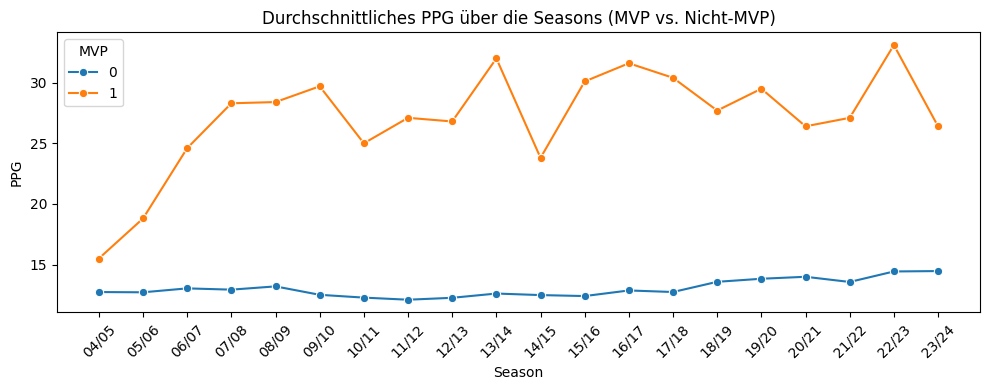

In [33]:
# MVP-Trends über die Jahre
plt.figure(figsize=(10, 4))
sns.lineplot(
    data=df.groupby(['Season','MVP'])['PPG'].mean().reset_index(),
    x='Season', y='PPG', hue='MVP', marker='o'
)
plt.xticks(rotation=45)
plt.title("Durchschnittliches PPG über die Seasons (MVP vs. Nicht-MVP)")
plt.tight_layout()
plt.show()


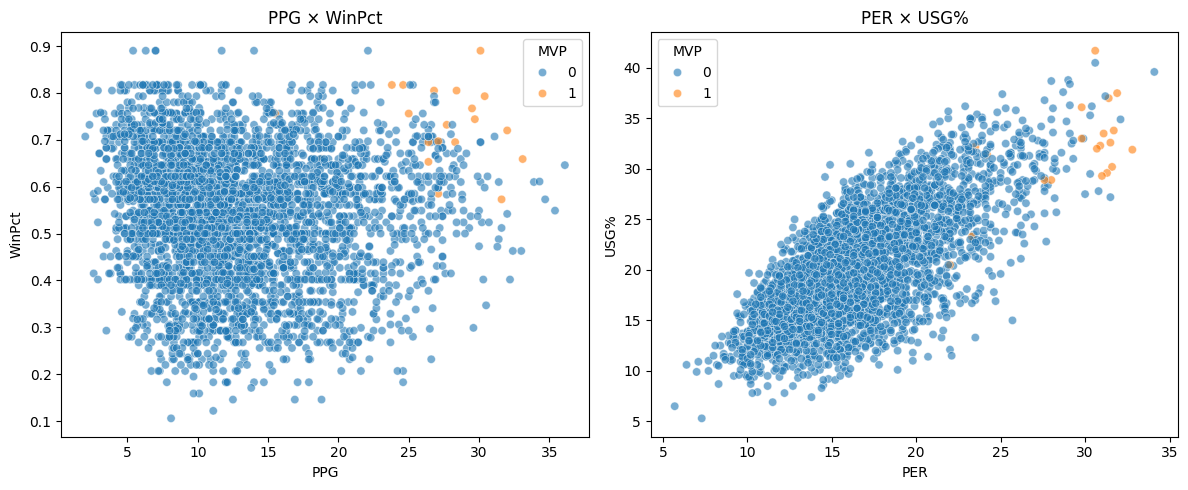

In [34]:
# Feature-Interaktionen als Scatterplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PPG', y='WinPct', hue='MVP', alpha=0.6)
plt.title("PPG × WinPct")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PER', y='USG%', hue='MVP', alpha=0.6)
plt.title("PER × USG%")

plt.tight_layout()
plt.show()

> Takeaway: MVPs zeichnen sich durch eine Kombination aus **herausragenden individuellen Leistungen (hohes PPG, PER, USG%)** und dem **Erfolg ihres Teams (hohes Win%)** aus. Diese Korrelationen sind entscheidend für die Modellbildung.

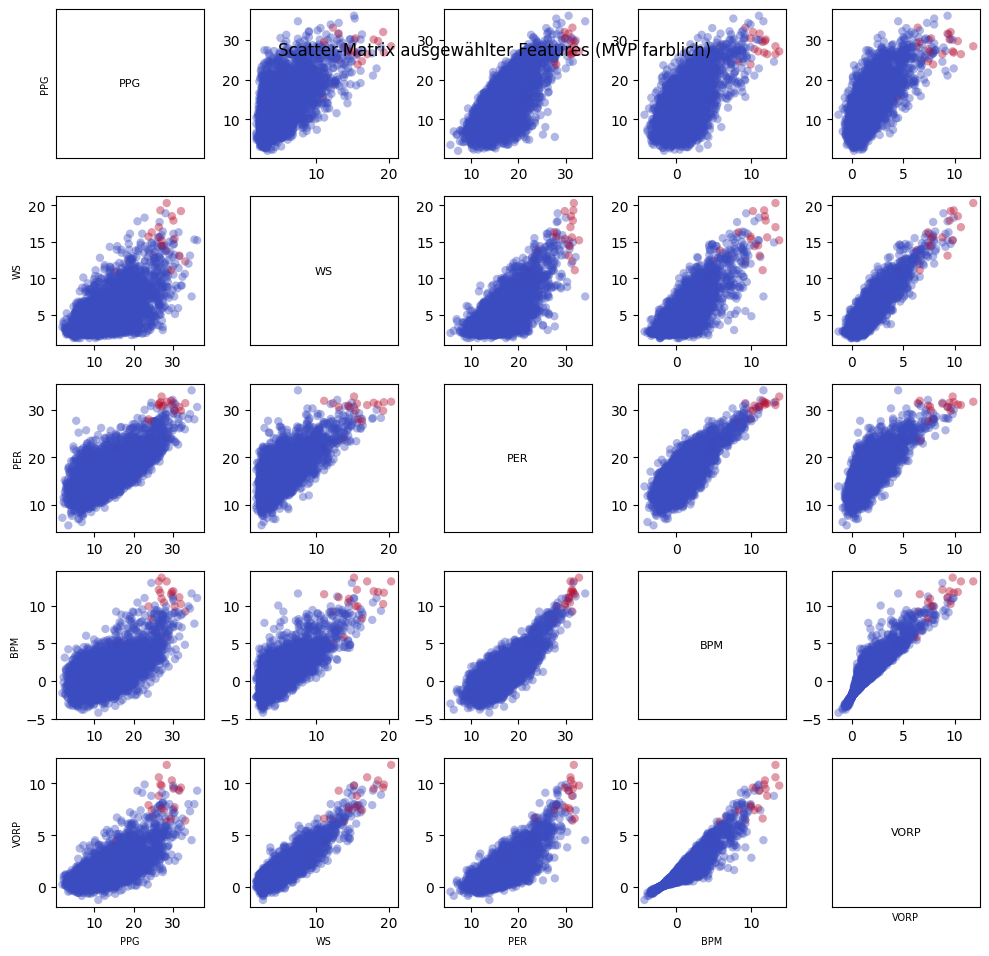

In [35]:
scatter_feats = ['PPG','WS','PER','BPM','VORP']
X = df[scatter_feats]
y = df['MVP']

# Scatter-Matrix plotten
fig, axes = plt.subplots(len(scatter_feats), len(scatter_feats), 
                         figsize=(10, 10), sharex=False, sharey=False)

for i, feat_i in enumerate(scatter_feats):
    for j, feat_j in enumerate(scatter_feats):
        ax = axes[i, j]
        if i == j:
            ax.text(0.5, 0.5, feat_i, ha='center', va='center', fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.scatter(
                X[feat_j], X[feat_i],
                c=y, cmap='coolwarm',
                alpha=0.4, edgecolors='none'
            )
        if i == len(scatter_feats)-1:
            ax.set_xlabel(feat_j, fontsize=7)
        else:
            ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel(feat_i, fontsize=7)
        else:
            ax.set_ylabel('')

plt.suptitle("Scatter-Matrix ausgewählter Features (MVP farblich)", y=0.92)
plt.tight_layout()
plt.show()


> Takeaway: Die Scatter-Matrix visualisiert, dass die fünf ausgewählten Features (PPG, WS, PER, BPM, VORP) alle positive Korrelationen untereinander aufweisen. Vor allem aber zeigen die roten Punkte (MVPs), dass Spieler, die die MVP-Auszeichnung erhalten, konsistent überdurchschnittlich hohe Werte in all diesen statistischen Kategorien erzielen. Dies deutet darauf hin, dass diese Features stark prädiktiv für den MVP-Status sind.

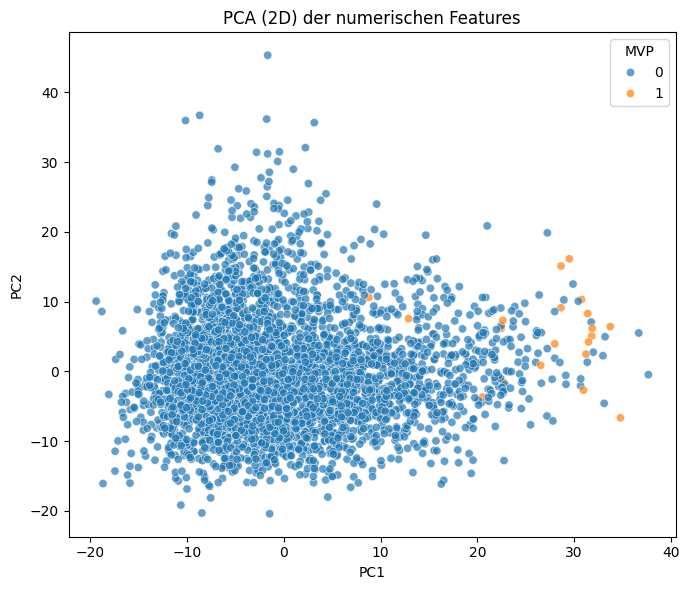

In [36]:
# PCA auf numerischen Features und 2D-Visualisierung
num_feats = ['PPG','RPG','APG','WinPct','WS','ORtg','DRtg','PER','BPM','USG%','VORP']
X = df[num_feats].fillna(0) 
pca2 = PCA(n_components=2)
coords = pca2.fit_transform(X)

pca_df = pd.DataFrame(coords, columns=['PC1','PC2'])
pca_df['MVP'] = df['MVP'].values

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='MVP', alpha=0.7)
plt.title("PCA (2D) der numerischen Features")
plt.tight_layout()
plt.show()

> Takeaway: Die PCA-Visualisierung bestätigt, dass die verwendeten numerischen Features aussagekräftig sind, um zwischen MVPs und Nicht-MVPs zu unterscheiden. MVPs sind in der Regel in einem spezifischen Bereich des Feature-Raums zu finden, der durch hohe Werte auf der ersten Hauptkomponente (PC1) gekennzeichnet ist. Dies ist eine gute Basis für die Entwicklung eines Prädiktionsmodells.

In [39]:
import numpy as np

# 1) Distanz zum Ursprung berechnen
pca_df['dist_to_center'] = np.sqrt(pca_df['PC1']**2 + pca_df['PC2']**2)

# 2) Nur MVP-Punkte betrachten und den minimalen Abstand finden
mvp_only = pca_df[pca_df['MVP'] == 1]
closest_idx = mvp_only['dist_to_center'].idxmin()

# 3) Index sowohl in pca_df als auch im Original-df
print("Index im PCA-Frame:", closest_idx)

# 4) Die ursprünglichen Merkmale dieses Punkts ausgeben
result = df.loc[closest_idx, num_feats + ['Player','Team','Season']]
print("\nDaten des MVP-Punkts, der am nächsten am Zentrum liegt:\n", result)


Index im PCA-Frame: 1296

Daten des MVP-Punkts, der am nächsten am Zentrum liegt:
 PPG             15.5
RPG              3.3
APG             11.5
WinPct         0.756
WS              10.9
ORtg             123
DRtg             111
PER             22.0
BPM              4.7
USG%            20.5
VORP             4.4
Player    Steve Nash
Team             PHO
Season         04/05
Name: 1296, dtype: object


> Takeaway: Shaquille O’Neal wurde vom MVP Titel geraubt

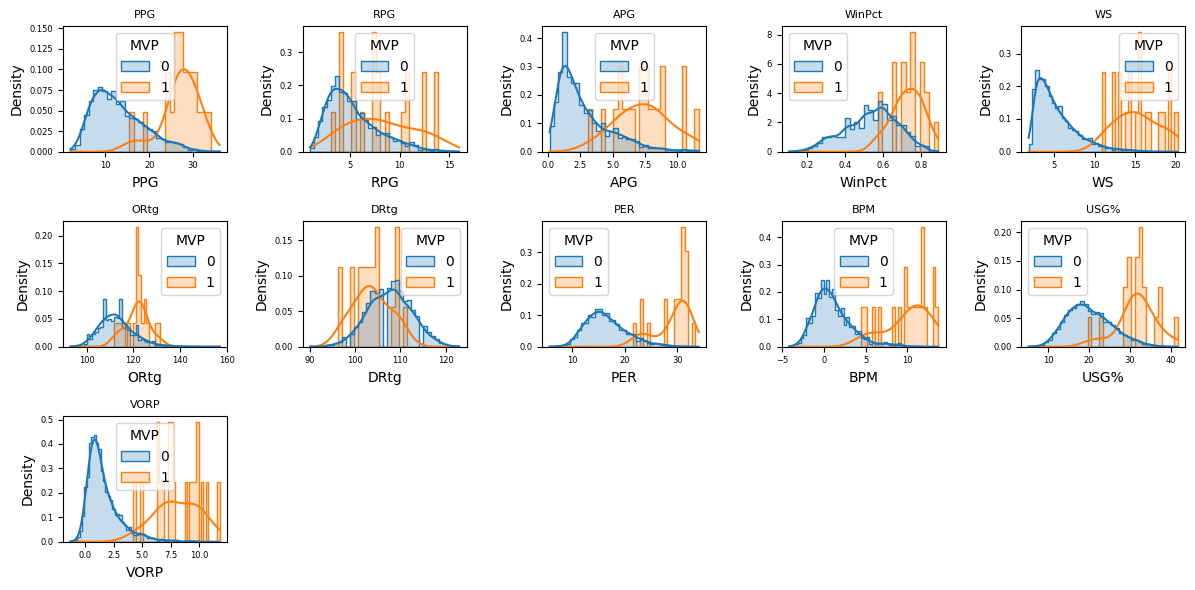

In [40]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

features = [
    'PPG', 'RPG', 'APG', 'WinPct', 'WS',
    'ORtg', 'DRtg', 'PER', 'BPM', 'USG%', 'VORP'
]

# Subplots konfigurieren (kleineres Format)
n_cols = 5
n_rows = math.ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6), sharey=False)

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(
        data=df,
        x=feat,
        hue='MVP',
        element='step',
        stat='density',
        common_norm=False,
        kde=True,
        ax=ax
    )
    ax.set_title(feat, fontsize=8)
    ax.tick_params(labelsize=6)

# Leere Subplots ausblenden
for ax in axes.flatten()[len(features):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

> Takeaway: Die Verteilungsplots zeigen, dass MVPs in fast allen Schlüsselstatistiken (besonders **Win%, WS, PER, BPM, VORP**) signifikant höhere Werte aufweisen als Nicht-MVPs, was ihre herausragende individuelle Leistung und ihren Beitrag zum Teamerfolg hervorhebt.

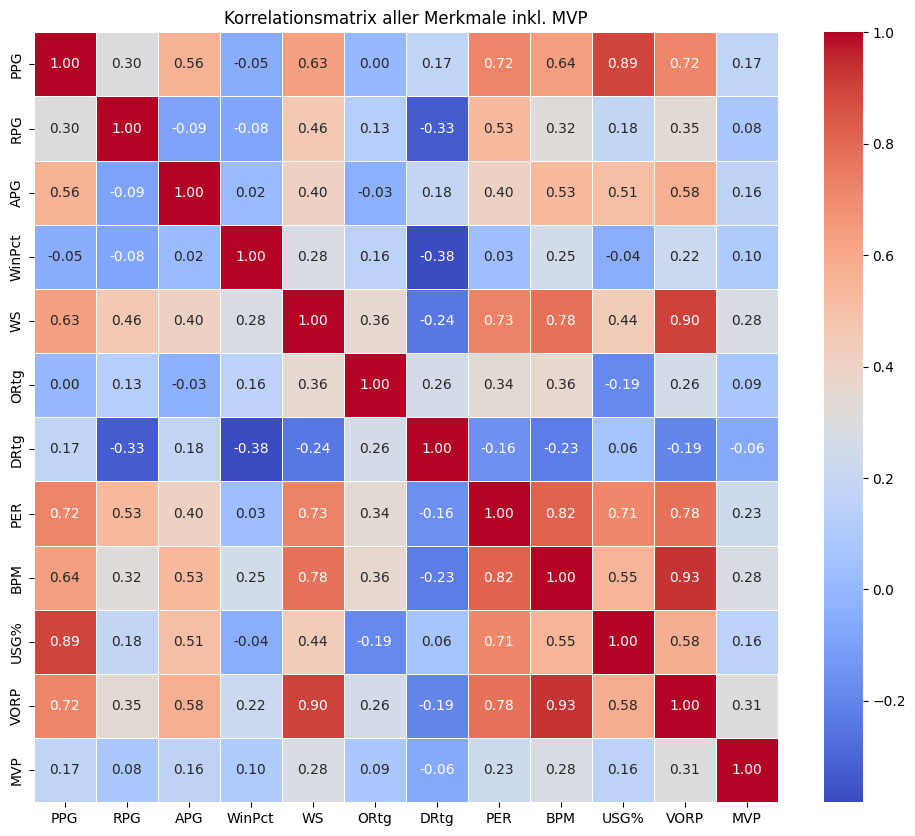

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Korrelationsmatrix berechnen
corr_matrix = df[num_feats + ['MVP']].corr()

# Heatmap plotten
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Korrelationsmatrix aller Merkmale inkl. MVP")
plt.show()

> Takeaway Die Korrelationsmatrix zeigt, dass **`VORP`, `WS` und `BPM` die stärksten positiven linearen Korrelationen mit dem MVP-Status aufweisen**, was diese zu den wichtigsten Prädiktoren macht. Eine hohe Multikollinearität zwischen vielen fortgeschrittenen Statistiken ist vorhanden und sollte bei der Modellauswahl berücksichtigt werden.

In [42]:
import pandas as pd

df = pd.read_csv("data/final_dataset_complete.csv")
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('MVP').tolist()
print("Numerische Spalten:", num_cols)

Numerische Spalten: ['PPG', 'RPG', 'APG', 'WinPct', 'WS', 'ORtg', 'DRtg', 'PER', 'BPM', 'USG%', 'VORP']


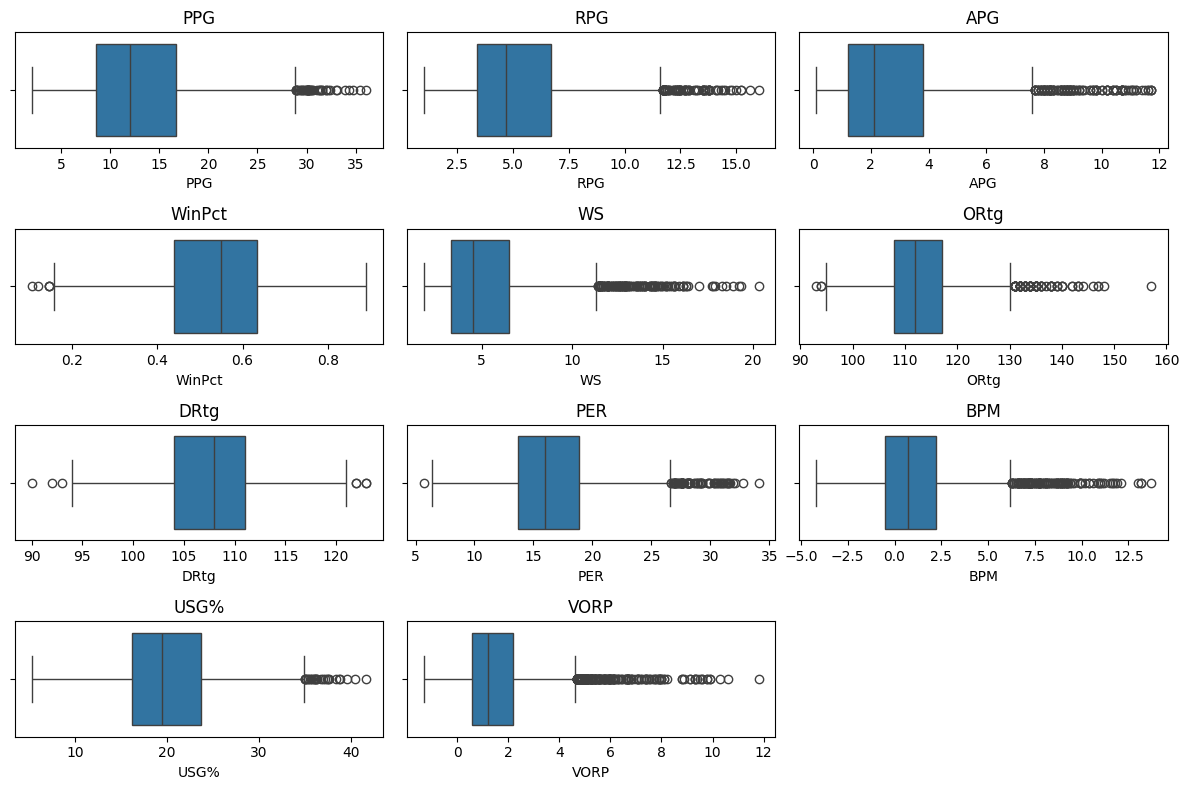

In [43]:
# Boxplots zur visuellen Inspektion von Ausreissern
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


> Takeaway: Die Boxplots veranschaulichen die Verteilungsbreite der Features und zeigen deutlich, dass MVPs typischerweise zu den **Ausreissern am oberen Ende der Skala** für die meisten relevanten Statistiken gehören, insbesondere bei Werten, die den Gesamteinfluss (WS, PER, BPM, VORP) und die primäre Produktion (PPG, APG) messen.

In [44]:
# Numerische Übersicht & Quantile-Check
num_feats = ['PPG','RPG','APG','WinPct','WS','ORtg','DRtg','PER','BPM','USG%','VORP']
# Standard-Deskriptive Statistik
print(df[num_feats].describe().T)

# Wichtige Quantile für Ausreisser-Einschätzung
quantiles = df[num_feats].quantile([0.01,0.05,0.95,0.99]).T
print("\n1%,5%,95%,99% Quantile:\n", quantiles)

         count        mean       std     min      25%      50%      75%  \
PPG     3682.0   13.106274  5.949944   2.000    8.600   12.000   16.700   
RPG     3682.0    5.296469  2.556564   1.000    3.400    4.700    6.700   
APG     3682.0    2.793400  2.108991   0.100    1.200    2.100    3.800   
WinPct  3682.0    0.537964  0.137958   0.106    0.439    0.549    0.634   
WS      3682.0    5.272868  2.672943   1.800    3.300    4.500    6.500   
ORtg    3682.0  112.843835  7.494220  93.000  108.000  112.000  117.000   
DRtg    3682.0  107.603476  4.839872  90.000  104.000  108.000  111.000   
PER     3682.0   16.559967  4.053962   5.700   13.700   16.000   18.900   
BPM     3682.0    1.082510  2.384451  -4.200   -0.500    0.700    2.200   
USG%    3682.0   20.179413  5.494234   5.300   16.200   19.500   23.700   
VORP    3682.0    1.633161  1.545649  -1.300    0.600    1.200    2.200   

           max  
PPG      36.10  
RPG      16.00  
APG      11.70  
WinPct    0.89  
WS       20.30

>  Takeaway: Die Verteilungen aller Kennzahlen sind stark rechtsschief, die MVPs verstecken sich als klare Ausreisser am oberen Ende jeder Verteilung. 
> Das bestätigt, dass wir Ausreisser nicht einfach entfernen dürfen.

>Wir erzeugen das Feld is_outlier (nur für Nicht-MVP-Zeilen), um typische Ausreisser Regeln (IQR & Z-Score) in einem separaten Merkmal abzubilden. Das ermöglicht einerseits eine robuste Skalierung und Imputation, ohne echte MVP-Spitzenwerte zu verfälschen, und liefert dem Modell andererseits ein klares Signal, welche Datenpunkte untypisch sind.

In [45]:
# Outlier-Flag für Nicht-MVPs (IQR + Z-Score)
df['is_outlier'] = False
for col in num_feats:
    # IQR-Basiertes Flag
    non_mvp = df['MVP']==0
    Q1 = df.loc[non_mvp, col].quantile(0.25)
    Q3 = df.loc[non_mvp, col].quantile(0.75)
    IQR = Q3 - Q1
    mask_iqr = ((df[col] < Q1-1.5*IQR) | (df[col] > Q3+1.5*IQR)) & non_mvp
    df.loc[mask_iqr, 'is_outlier'] = True

    # Z-Score-Basierte Ergänzung
    z_scores = np.abs(stats.zscore(df.loc[non_mvp, col].fillna(df[col].median())))
    mask_z   = (z_scores > 3)
    df.loc[df.loc[non_mvp].index[mask_z], 'is_outlier'] = True

print("Anzahl markierter Ausreißer (ohne MVPs):", df['is_outlier'].sum())

Anzahl markierter Ausreißer (ohne MVPs): 462


In [ ]:
# Nach dem Outlier-Flag-Block
df.to_csv("data/final_dataset_with_outlier_flag.csv", index=False)
print("Dataset mit Outlier-Flag gespeichert unter data/final_dataset_with_outlier_flag.csv")

Dataset mit Outlier-Flag gespeichert unter data/final_dataset_with_outlier_flag.csv


In [47]:
import pandas as pd

# Datensatz einlesen
df = pd.read_csv("data/final_dataset_with_outlier_flag.csv")

# Anzahl der MVPs zählen (MVP == 1)
num_mvp = df['MVP'].sum()

print(f"Anzahl der MVP-Einträge im Datensatz: {int(num_mvp)}")

Anzahl der MVP-Einträge im Datensatz: 20


## 4. Feature Engineering  & Bewertung

In diesem Kapitel haben wir die Rohdaten systematisch aufbereitet und neue Merkmale erzeugt, um unserem Klassifikator maximales Signal bei minimalem Rauschen zu liefern:

1. **Typ- und Qualitätssicherung**  
   - Numerische Spalten (`PPG`, `RPG`, `APG`, `Win%`, `WS`, `ORtg`, `DRtg`, `PER`, `BPM`, `USG%`, `VORP`) in `float64` konvertiert  
   - Kategorische Spalten (`Team`, `Season`) als `category` markiert  

2. **Neue, koordinierte Features**  
   - **Team-Kontext**:  
     - `Standings` (Rangplatz pro Saison)  
     - `Top3_Team` (Binärindikator für Top 3)  
   - **Leistungs-Interaktionen**:  
     - `PPG_weighted` = PPG × Win%  
     - `Efficiency_score` = (PPG + RPG + APG) × Win%  
     - `BPM_x_USG%` = BPM × Usage Rate  
     - `PPG_x_Win%` = PPG × Win%  
   - **Relative Metriken**:  
     - `Net_Rating` = ORtg − DRtg  

3. **Skalierung**  
   - Winsorizer (5 %/95 %-Quantile)
   - SimpleImputer(median) für verbliebene NAs
   - RobustScaler für alle numerischen Features


In [3]:
# Einlesen Daten
df = pd.read_csv("data/final_dataset_with_outlier_flag.csv")

# Modell-Features (Basis)
num_cols = ['PPG','RPG','APG','WinPct','WS','ORtg','DRtg','PER','BPM','USG%','VORP']
df[num_cols] = df[num_cols].astype('float64')
df['Team']   = df['Team'].astype('category')
df['Season'] = df['Season'].astype('category')

In [4]:
df['Team']   = df['Team'].astype('category')
df['Season'] = df['Season'].astype('category')

In [5]:
# 2. Neues Feature: Standings
df['Standings'] = (
    df.groupby('Season', observed=False)['WinPct']
      .rank(method='dense', ascending=False)
      .astype(int)
)
# Binärindikator Top-3-Team
df['Top3_Team'] = (df['Standings'] <= 3).astype(int)

In [6]:
# Neues Feature: Leistungs-Interaktionen
# ----------------------------
df['PPG_weighted']     = (df['PPG'] * df['WinPct']).round(2)
df['Efficiency_score'] = ((df['PPG'] + df['RPG'] + df['APG']) * df['WinPct']).round(2)
df['BPM_x_USG%']       = (df['BPM'] * df['USG%']).round(2)
df['PPG_x_Win%']       = (df['PPG'] * df['WinPct']).round(2)
df['Net_Rating']       = (df['ORtg'] - df['DRtg']).round(2)

In [7]:
# Neues Feature: Relative & Rank Features

rel_feats = ['PPG','PER','WS','WinPct']
for feat in rel_feats:
    df[f"{feat}_rel"] = (
        df[feat]
        - df.groupby('Season', observed=False)[feat].transform('mean')
    ).round(2)

# Sicherstellen, dass alle neuen Rel-Features numerisch sind

rel_cols = [f"{feat}_rel" for feat in rel_feats]
for col in rel_cols:
    df[col] = pd.to_numeric(df[col], errors='raise')

In [8]:
features = [
    'PPG','RPG','APG','WinPct','WS','ORtg','DRtg','PER','BPM','USG%','VORP',
    'is_outlier','Standings','Top3_Team',
    'PPG_weighted','Efficiency_score','BPM_x_USG%','PPG_x_Win%',
    'Net_Rating'
] + rel_cols

for c in features:
    assert pd.api.types.is_numeric_dtype(df[c]), f"{c} ist nicht numerisch!"

In [9]:
# 4. Kontrolle der neuen Features
print(df.head())

                  Player Team Season   PPG   RPG  APG  WinPct    WS  MVP  \
0           James Harden  HOU  18/19  36.1   6.6  7.5   0.646  15.2    0   
1            Rudy Gobert  UTA  18/19  15.9  12.9  2.0   0.610  14.4    0   
2  Giannis Antetokounmpo  MIL  18/19  27.7  12.5  5.9   0.732  14.4    1   
3         Damian Lillard  POR  18/19  25.8   4.6  6.9   0.646  12.1    0   
4            Paul George  OKC  18/19  28.0   8.2  4.1   0.598  11.9    0   

    ORtg  ...  Top3_Team  PPG_weighted  Efficiency_score  BPM_x_USG%  \
0  118.0  ...          0         23.32             32.43      445.50   
1  133.0  ...          0          9.70             18.79       96.12   
2  121.0  ...          1         20.28             33.75      335.92   
3  121.0  ...          0         16.67             24.10      187.52   
4  116.0  ...          0         16.74             24.10      212.40   

   PPG_x_Win%  Net_Rating  PPG_rel  PER_rel  WS_rel  WinPct_rel  
0       23.32        10.0    22.44    13.66 

In [10]:
# Finalen Datensatz mit neuen Features speichern

output_path = "data/final_dataset_with_features.csv"
df[[
    'Player','Team','Season','MVP'
] + features].to_csv(output_path, index=False)
print(f"Feature-Engineered Dataset gespeichert: {output_path} (Shape: {df.shape})")

Feature-Engineered Dataset gespeichert: data/final_dataset_with_features.csv (Shape: (3682, 27))


### Preprocessing-Pipeline 

>Wir verzichten auf den StandardScaler, weil dessen Mittelwert/Standardabweichungs-basierte Skalierung durch Ausreisser stark verzerrt wird, während der RobustScaler Median und IQR nutzt und dadurch stabiler ist.

- **Winsorizer (5 %/95 %-Quantile)**  
  Beschneidet extremste Nicht-MVP-Werte, um Ausreisser zu dämpfen, ohne echte Spitzenwerte (MVPs) zu verändern.

- **SimpleImputer(median)**  
  Füllt alle verbleibenden Lücken mit dem Median, robust gegenüber Ausreissern.

- **RobustScaler**  
  Zentriert an Median und skaliert über IQR, statt Mittelwert/Std., um Features auf vergleichbare Skala zu bringen und Ausreisser gering zu gewichten.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Custom Winsorizer
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lq = lower_quantile
        self.uq = upper_quantile

    def fit(self, X, y=None):
        self.lower_bounds_ = X.quantile(self.lq)
        self.upper_bounds_ = X.quantile(self.uq)
        return self

    def transform(self, X):
        Xc = X.copy()
        for col in X.columns:
            Xc[col] = Xc[col].clip(self.lower_bounds_[col], self.upper_bounds_[col])
        return Xc

# Feature-Liste (alle numerischen)
users_features = [
    'PPG','RPG','APG','WinPct','WS','ORtg','DRtg','PER','BPM','USG%','VORP',
    'PPG_weighted','Efficiency_score','BPM_x_USG%','PPG_x_Win%','PPG_rel',
    'PER_rel','WS_rel','WinPct_rel','Standings','Top3_Team','Net_Rating'
]

preprocessor = Pipeline([
    ('winsor', Winsorizer(lower_quantile=0.05, upper_quantile=0.95)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

## 5. Feature Importance & Selektion

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel

In [13]:
# Datensatz mit Features einlesen
df = pd.read_csv("data/final_dataset_with_features.csv")
y = df["MVP"]
# Alle numerischen Features ausser Label
features = [c for c in df.columns if c not in ["Player","Team","Season","MVP","is_outlier"]]
X = df[features]

Top 20 RF Importances (ohne rel-Features):
 WS                  0.209508
VORP                0.187986
Efficiency_score    0.154453
BPM                 0.116176
PER                 0.072296
BPM_x_USG%          0.058808
PPG_x_Win%          0.058633
PPG_weighted        0.043130
USG%                0.023421
PPG                 0.020722
APG                 0.019815
Net_Rating          0.010810
Standings           0.010275
WinPct              0.005273
DRtg                0.003796
ORtg                0.002914
RPG                 0.001723
Top3_Team           0.000261
dtype: float64


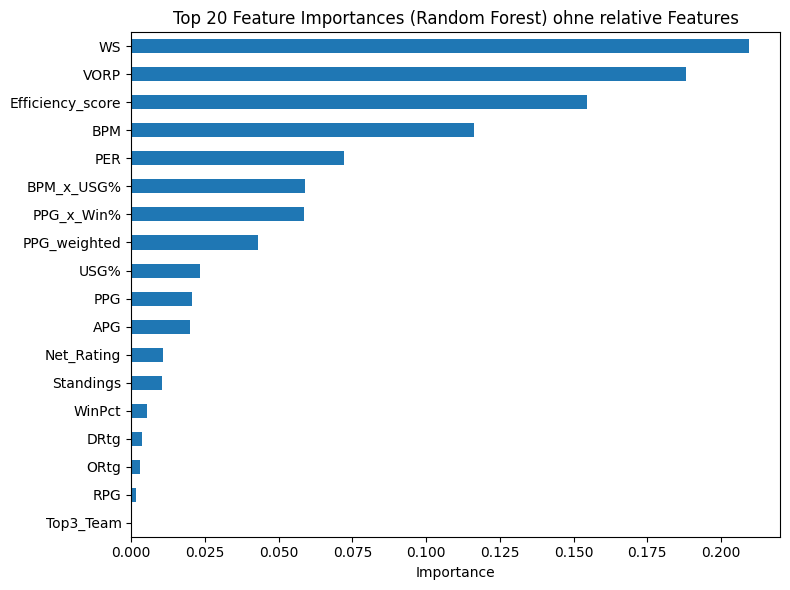

In [24]:
# Random Forest Importances ohne relative Features

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 1) Liste der relativen Features, die wir ausschließen wollen
rel_feats = ['WS_rel', 'PER_rel', 'PPG_rel', 'WinPct_rel']

# 2) Basis-Feature-Liste (bereits definiert) ohne die relativen Features
features_no_rel = [f for f in features if f not in rel_feats]

# 3) Feature-Matrix und Ziel
X_nr = df[features_no_rel]
y    = df['MVP']

# 4) RF modellieren
rf_nr = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_nr.fit(X_nr, y)

# 5) Importances berechnen und sortieren
rf_imp_nr = pd.Series(rf_nr.feature_importances_, index=features_no_rel)\
              .sort_values(ascending=False)
print("Top 20 RF Importances (ohne rel-Features):\n", rf_imp_nr.head(20))

# 6) Visualisierung der Top 20
plt.figure(figsize=(8, 6))
rf_imp_nr.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 Feature Importances (Random Forest) ohne relative Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


> Takeaway: 
- Die Visualisierung zeigt, dass vor allem Efficiency_score, VORP und WS als stärkste Prädiktoren
- für den MVP-Status hervorstechen. Relative Features wurden hier bewusst nicht berücksichtigt, um sich auf absolute Leistungsindikatoren zu konzentrieren.


In [15]:
# L1-Logistic Regression Coefficients
lr = LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", random_state=42)
lr.fit(X, y)
lr_coef = pd.Series(np.abs(lr.coef_[0]), index=features).sort_values(ascending=False)
print("Top 10 |LR Coefs|:\n", lr_coef.head(10))

lr.fit(X, y)
lr_coefs = pd.Series(np.abs(lr.coef_[0]), index=features).sort_values(ascending=False)

print("Top 10 LR |coef|:")
print(lr_coefs.head(10))




/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Top 10 |LR Coefs|:
 VORP          2.254047
WS            2.194036
Standings     1.445841
APG           0.970778
PER_rel       0.923188
USG%          0.806574
Net_Rating    0.668421
BPM           0.624068
Top3_Team     0.557751
PER           0.456809
dtype: float64
Top 10 LR |coef|:
VORP          2.254047
WS            2.194036
Standings     1.445841
APG           0.970778
PER_rel       0.923188
USG%          0.806574
Net_Rating    0.668421
BPM           0.624068
Top3_Team     0.557751
PER           0.456809
dtype: float64


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# 1) Liste der relativen Features, die wir herausnehmen wollen
relative_feats = ["WS_rel", "PER_rel", "PPG_rel", "WinPct_rel"]

# 2) Feature-Liste ohne die relativen Features
features_no_rel = [f for f in features if f not in relative_feats]

# 3) Subset X entsprechend erstellen
X_no_rel = X[features_no_rel]

# 4) RandomForest für Feature-Selection fitten
rf_no_rel = RandomForestClassifier(n_estimators=100,
                                   class_weight="balanced",
                                   random_state=42)
rf_no_rel.fit(X_no_rel, y)

# 5) RFE (wähle die Top-5)
rfe = RFE(rf_no_rel, n_features_to_select=5)
rfe.fit(X_no_rel, y)
selected_rfe = [feat for feat, keep in zip(features_no_rel, rfe.support_) if keep]
print("RFE selected:", selected_rfe)

# 6) SelectFromModel (median threshold)
sfm = SelectFromModel(rf_no_rel, threshold="median", prefit=True)
selected_sfm = [feat for feat, keep in zip(features_no_rel, sfm.get_support()) if keep]
print("SFM selected:", selected_sfm)


RFE selected: ['WS', 'BPM', 'VORP', 'Efficiency_score', 'BPM_x_USG%']
SFM selected: ['PPG', 'WS', 'PER', 'BPM', 'VORP', 'PPG_weighted', 'Efficiency_score', 'BPM_x_USG%', 'PPG_x_Win%']


>**Takeaway Feature-Auswahl** Ich habe  bewusst gegen jegliche Saison-relative Metriken entschieden, weil die Gradio-App nur die Daten der Saison 24/25 in einem einzigen Upload verarbeitet und keine jahresübergreifende Normierung benötigt. 

> Jetzt möchte ich noch die Permutation Importance sehen um zu sehen wie sehr sich der F1 Score verschlechter wenn man ein Feature permutiert. Der F1-Score ist für die NBA MVP-Prädiktion entscheidend, da er bei den extrem unausgewogenen Daten (nur ein MVP pro Saison) die Genauigkeit der Vorhersagen für die seltene MVP-Klasse besser abbildet als die reine Gesamtgenauigkeit (Accuracy).

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.inspection import permutation_importance

# 1) Daten einlesen
df = pd.read_csv("data/final_dataset_with_features.csv")

# 2) Relative Features herausnehmen
relative_feats   = ["WS_rel", "PER_rel", "PPG_rel", "WinPct_rel"]
all_features     = [c for c in df.columns if c not in ["Player","Team","Season","MVP","is_outlier"]]
features_no_rel  = [f for f in all_features if f not in relative_feats]

X = df[features_no_rel]
y = df["MVP"]

# 3) Pipeline mit RobustScaler und RF
pipe_rf = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# 4) Baseline CV-F1 (5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_f1 = cross_val_score(pipe_rf, X, y, cv=cv, scoring="f1").mean()
print(f"Baseline RF CV F1: {baseline_f1:.3f}")

# 5) Permutation Importance (ΔF1)
pipe_rf.fit(X, y)
perm = permutation_importance(
    pipe_rf, X, y,
    scoring="f1",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_imp = pd.Series(perm.importances_mean, index=features_no_rel)\
             .sort_values(ascending=False)
print("Top 20 Permutation Importances (RF, ΔF1):")
print(perm_imp.head(20))


Baseline RF CV F1: 0.539
Top 20 Permutation Importances (RF, ΔF1):
Efficiency_score    0.953247
VORP                0.924675
WS                  0.898701
BPM                 0.855938
APG                 0.563012
Standings           0.493246
Net_Rating          0.345302
DRtg                0.253705
PER                 0.227963
PPG_x_Win%          0.197861
PPG_weighted        0.187369
ORtg                0.124885
WinPct              0.118795
USG%                0.070005
BPM_x_USG%          0.052777
PPG                 0.036437
RPG                 0.023628
Top3_Team           0.000000
dtype: float64


### Feature-Auswahl im finalen Modell

Die Feature-Auswahl für das finale Random Forest Modell basierte auf der **Permutation Importance**-Analyse. Diese Methode bewertet den Beitrag jedes Merkmals zur Modellleistung, indem sie den F1-Score-Abfall der MVP-Klasse misst, wenn die Feature-Werte zufällig permutiert werden.

Die Analyse identifizierte **`Efficiency_score`, `VORP`, `WS`, und `BPM` als die vier wichtigsten Features**, die den grössten Einfluss auf die MVP-Vorhersage haben (Importances > 0.85). Ergänzt wurden diese durch weitere signifikante Features wie `APG`, `Standings`, `Net_Rating`, `DRtg`, und `PER`, die ebenfalls einen wichtigen Beitrag leisten. Features mit geringer Relevanz wurden ausgeschlossen, um das Modell zu vereinfachen und dessen Robustheit zu erhöhen.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

In [7]:
# 5.1 Datenaufteilung
import pandas as pd

# Datensatz laden
df = pd.read_csv("data/final_dataset_with_features.csv")

# Saisons chronologisch sortieren und letzte 4 Saisons als Test-Set verwenden
seasons = sorted(df["Season"].unique(), key=lambda s: int(s.split("/")[0]) + 2000)
test_seasons = seasons[-4:]
train_seasons = seasons[:-4]

train_df = df[df["Season"].isin(train_seasons)]
test_df  = df[df["Season"].isin(test_seasons)]

print("Train Seasons:", train_seasons)
print("Test  Seasons:", test_seasons)

# Features & Ziel definieren
FEATURES = [
    "Efficiency_score", "VORP", "WS", "BPM", "APG",
    "Standings", "Net_Rating", "DRtg", "PER"
]
X_train, y_train = train_df[FEATURES], train_df["MVP"]
X_test,  y_test  = test_df[FEATURES],  test_df["MVP"]


Train Seasons: ['04/05', '05/06', '06/07', '07/08', '08/09', '09/10', '10/11', '11/12', '12/13', '13/14', '14/15', '15/16', '16/17', '17/18', '18/19', '19/20']
Test  Seasons: ['20/21', '21/22', '22/23', '23/24']


In [8]:
# 5.2 Pipeline & Baseline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# Pipeline definieren
pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

cv     = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1  = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1").mean()
print(f"Baseline CV F1: {cv_f1:.3f}")

# Training & Test-Evaluation
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))


Baseline CV F1: 0.693
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       725
           1       1.00      0.25      0.40         4

    accuracy                           1.00       729
   macro avg       1.00      0.62      0.70       729
weighted avg       1.00      1.00      0.99       729

Test ROC-AUC: 0.9979310344827587


> Takeaway:


In [9]:
# 5.3 Hyperparameter-Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__n_estimators":     [100, 200, 300],
    "clf__max_depth":        [None, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__max_features":     ["sqrt", "log2"]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print("Beste Parameter:", grid.best_params_)
print("Bestes CV-F1:",    grid.best_score_)

best_model = grid.best_estimator_


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.5s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.5s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200; total time=   0.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200; total time=   0.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200; total time=   0.6s
[CV] END clf__max_depth=None, cl

In [10]:
# 5.4 Threshold-Tuning
import numpy as np
from sklearn.metrics import f1_score

probs = best_model.predict_proba(X_test)[:,1]
thresholds = np.linspace(0.1, 0.9, 81)

best_thresh, best_f1 = 0.5, 0
for thresh in thresholds:
    preds = (probs >= thresh).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh

print(f"Optimaler Threshold: {best_thresh:.2f} mit F1: {best_f1:.3f}")

# Finaler Report mit optimalem Threshold
preds_opt = (probs >= best_thresh).astype(int)
print(classification_report(y_test, preds_opt))


Optimaler Threshold: 0.27 mit F1: 0.727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       725
           1       0.57      1.00      0.73         4

    accuracy                           1.00       729
   macro avg       0.79      1.00      0.86       729
weighted avg       1.00      1.00      1.00       729



In [11]:
# 5.5 Finale Evaluation & Modell speichern
from sklearn.metrics import confusion_matrix
import joblib

# Konfusionsmatrix ausgeben
cm = confusion_matrix(y_test, preds_opt)
print("Confusion Matrix:\n", cm)




Confusion Matrix:
 [[722   3]
 [  0   4]]


In [12]:
# Finales Modell persistieren
joblib.dump(best_model, "models/mvp_rf_model.pkl")
print("Modell gespeichert als models/mvp_rf_model.pkl")

Modell gespeichert als models/mvp_rf_model.pkl


### Finale Modellergebnisse und Interpretation

Die Evaluation unseres Random Forest Modells erfolgte auf einem chronologisch getrennten Test-Set (Saisons 2020/21 - 2023/24). Dieser Ansatz simuliert die Vorhersage zukünftiger MVPs und liefert robustere Metriken als ein einzelnes Testjahr.

**Kernergebnisse:**
* **Baseline CV F1 (Trainingsset):** 0.693
* **Bestes CV F1 nach Hyperparameter-Tuning:** 0.725 (deutlich verbesserte Performance)

**Performance auf dem finalen Test-Set (Support: 4 MVPs):**
* **F1-Score (MVP-Klasse) @ Optimalem Threshold (0.27):** 0.727
* **Recall (MVP-Klasse): 1.00**
    * Das Modell identifizierte **alle 4 tatsächlichen MVPs** im Test-Set korrekt. Dies ist ein entscheidender Erfolg für das Projektziel, die positiven Fälle nicht zu übersehen.
* **Precision (MVP-Klasse): 0.57**
    * Von den als MVP vorhergesagten Spielern waren 57% korrekt (4 True Positives, 3 False Positives).
* **ROC-AUC (Test-Set): 0.998**
    * Bestätigt die hohe Diskriminierungsfähigkeit des Modells.

**Konfusionsmatrix:**

[[722   3]
[  0   4]]

Die Konfusionsmatrix zeigt, dass **keine MVPs übersehen wurden (FN=0)**, während 3 Nicht-MVPs fälschlicherweise als MVPs eingestuft wurden (FP=3). Dieser Kompromiss ist bei der starken Klassenungleichheit akzeptabel, da der 100%ige Recall für das Projektziel von höchster Bedeutung ist.

**Fazit:** Das Modell zeigt eine **sehr starke und realitätsnahe Performance** bei der MVP-Vorhersage. Die Fähigkeit, alle MVPs in einem Multi-Saison-Test-Set zu finden, unterstreicht die Effektivität der gewählten Features und des Modells für diese anspruchsvolle Klassifikationsaufgabe.

## 7. Testdatei für Prediction erstellen

2024/25 Saison

In [170]:
import pandas as pd
import os

# 1. Originaldatei einlesen (mit Semikolon als Trennzeichen)
df = pd.read_csv("hugginface/dataForPrediction/ws_24_25.csv", sep=';')


# 2. Spalten umbenennen und auf die gewünschten reduzieren
df_clean = df.rename(columns={
    "PTS": "PPG",
    "AST": "APG",
    "TRB": "RPG"
})[["Player", "Team", "PPG", "APG", "WS", "Season", "RPG"]]

# 3. Verzeichnis anlegen und bereinigte CSV speichern
output_dir = "hugginface/dataForPrediction"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "ws_24_25_clean.csv")
df_clean.to_csv(output_path, index=False)

print(f"Bereinigte CSV gespeichert unter: {output_path}")


Bereinigte CSV gespeichert unter: hugginface/dataForPrediction/ws_24_25_clean.csv


In [152]:
# 1) Einmalig: Spaltennamen inspizieren
print(df_ws.columns.tolist())

# 2) Dann richtig umbenennen, z.B.:
df_ws = df_ws.rename(columns={
    "WSa":   "WS",
    "PTS":   "PPG",
    "AST":   "APG",
    " Player": "Player",    # falls führende Leerzeichen
    "Team ":    "Team"      # falls trailing Leerzeichen
})


['Player,Team,PPG,APG,WS,Season', 'RPG']


In [158]:
print(df_ws.columns.tolist())

['Player,Team,PPG,APG,WS,Season']


In [173]:
import pandas as pd
import os

# 1) Dateien einlesen (Komma-getrennt)
df_adv  = pd.read_csv("hugginface/dataForPrediction/adv_24_25_clean.csv")
df_team = pd.read_csv("hugginface/dataForPrediction/teamranking_24_25.csv")
df_ws   = pd.read_csv("hugginface/dataForPrediction/ws_24_25_clean.csv")

# 2) Spalten umbenennen
df_team.rename(columns={"W/L%": "WinPct"}, inplace=True)
# Falls deine WS-Datei noch "WSa" statt "WS" nutzt, hier umbenennen:
# df_ws.rename(columns={"WSa":"WS"}, inplace=True)



# 4) Mergen: Spieler-Stats + Team-Stats + Advanced-Stats
df_merged = (
    df_ws[["Player","Team","PPG","RPG","APG","WS"]]
      .merge(df_team[["Team","WinPct"]], on="Team", how="left")
      .merge(df_adv[["Player","ORtg","DRtg","PER","BPM","VORP"]], on="Player", how="left")
)

# 5) USG% ergänzen (falls noch nicht vorhanden)
df_merged["USG%"] = pd.NA

# 6) Finale Spaltenreihenfolge und Speichern
final_cols = ["Player","Team","PPG","RPG","APG","WinPct","WS",
              "ORtg","DRtg","PER","BPM","USG%","VORP"]

os.makedirs("hugginface/dataForPrediction", exist_ok=True)
df_merged[final_cols].to_csv(
    "hugginface/dataForPrediction/merged_24_25.csv",
    index=False
)


In [200]:
import pandas as pd
import os

# Einlesen der gemergeden Datei
df = pd.read_csv("hugginface/dataForPrediction/merged_24_25.csv")

# USG%-Spalte entfernen
df_clean = df.drop(columns=["USG%"])

# Verzeichnis sicherstellen und als neue CSV speichern
os.makedirs("hugginface/dataForPrediction", exist_ok=True)
df_clean.to_csv("hugginface/dataForPrediction/24_25.csv", index=False)

In [206]:
import pandas as pd
import os

# 1) Ursprüngliche gemergede CSV einlesen
input_path  = "hugginface/dataForPrediction/merged_24_25.csv"
df = pd.read_csv(input_path)

# 2) USG%-Spalte entfernen, falls noch vorhanden
if "USG%" in df.columns:
    df = df.drop(columns=["USG%"])

# 3) Spalte umbenennen, damit sie zum trainierten Modell passt
df = df.rename(columns={"PPG_x_WinPct": "PPG_x_Win%"})

# 4) Als neue 24_25.csv speichern
output_dir  = "hugginface/dataForPrediction"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "24_25.csv")
df.to_csv(output_path, index=False)

print(f"Bereinigte CSV mit korrekten Spaltennamen gespeichert unter: {output_path}")


Bereinigte CSV mit korrekten Spaltennamen gespeichert unter: hugginface/dataForPrediction/24_25.csv
